***Can We Predict Gaming Duration?***

**Introduction**

This project is based on the data of collected by researchers at the Pacific Laboratory for Artificial Intelligence (PLAI) who set up a private server for Minecraft. Players who join the server have their actions recorded. The goal of PLAI is to create an embodied AI that can be interacted with like a real person in virtual worlds (e.g., Minecraft). Check out more [here](https://plaicraft.ai/).

We will be using the same dataset, but with a different goal. The goal of this project will be to study how different features in the dataset contribute to gaming time. 

*More specifically, how do player experience level and age influence the total amount played?*

Our choice of predictors is based on our hypothesis that more experienced players generally enjoy the game more and thus tend to contribute more game time. We also hypothesize that younger players would have more free time and thus are more likely to have a higher hour played.

Before we get into it, let's take a look at the data we will be using. 

In [ ]:
library(dplyr)
library(ggplot2)
library(readr)
library(tidyverse)
library(tidymodels)

sessions <- read_csv("Data/sessions.csv")
head(sessions)
summary(sessions)
str(sessions)

- **Number of observations:**
    - 1535 observations
- **Number of variables:**
    - 5 variables
- **name and type of variables:**
                                                                    
| Name                | Type |
|---------------------|------|
| hashedEmail         | chr  |
| start_time          | chr  |
| end_time            | chr  |
| original_start_time | num  |
| original_end_time   | num  | 

- **What do the variables mean?:**
    - hashedEmail:
        - *these are the emails of users converted into unreadable strings*
    - start_time:
        - *Start time of a session in a human-readable format*
    - end_time:
        - *End time of a session in a human-readable format*
    - original_start_time:
        - *Start time in a format easier for computers*
    - original_end_time:
        - *End time in a format easier for computers*

In [ ]:
players <- read_csv("Data/players.csv")
head(players)
summary(players)
str(players)

- **Number of observations:**
    - 196 observations
- **Number of variables:**
    - 9 variables
- **name and type of variables:**
                                                                    
| Name             | Type |
|------------------|------|
| experience       | chr  |
| subscribe        | logi |
| hashedEmail      | chr  |
| played_hours     | num  |
| name             | chr  | 
| gender           | chr  |
| age              | num  |
| individualId     | logi |
| organizationName | logi |

- **What do the variables mean?:**
    - experience:
        - *What level players are at (pro, veteran, amateur, regular)*
    - subscribe:
        - *Whether or not the player has a subscription*
    - hashedEmail:
        - *Hashed version of player's email*
    - played_hours:
        - *How many hours a player has played*
    - name:
        - *Name of the player*
    - gender:
        - *Gender of the player*
    - age:
        - *Age of the player*
    - individualId:
        - *ID for player*
    - organizationName:
        - *Organization player is associated with*

In [ ]:
filtered_players <- players |>
filter(played_hours > 0 & played_hours <= 25)


filtered_players <- filtered_players |>
  mutate(
    experience = factor(
      experience,
      levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
      ordered = TRUE
    )
  )

filtered_players filters away the players with zero played_hours and played_hours above 25. This is to avoid outliers that significantly skews our data

In [ ]:
ggplot(filtered_players, aes(x = experience, y = played_hours)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(title = "Played Hours by Experience", x = "Experience", y = "Played Hours")

This visualization lets use see the total played hours between each of the experience categories. This way, we can gain a preliminary understnading of the distribution of play hours between each expereince level.

In [ ]:
ggplot(filtered_players, aes(x = age, y = played_hours)) +
    geom_point() +
    labs(title = "Age vs. Played Hours", x = "Age (years)", y = "Played Hours")

This visualization lets us gain an initial understanding about the relationsip between age and played hours in our dataset. This way, we can come up with a better plan to continue investigate the relationship between these two variables.

In [ ]:
avg_playtime <- filtered_players |>
    group_by(experience) |>
    summarize(avg_played_hours = mean(played_hours))

ggplot(avg_playtime, aes(x = experience, y = avg_played_hours)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(title = "Average Played Hours by Experience Level", x = "Experience Level", y = "Average Hours Played")

Instead of looking at total played hours in aggregate, this visualization allows us to understand how much each player in each experience level tends to play.

As the initial plotting of the data does not show any linear relationship between experience level and age with hours played, a more appropriate method to address my question would be KNN regression. This method is relevant because it doesn't assume linearity, making it more suitable for non-linear patterns. I must select the right k to balance the small details carefully but not be too noisy. I will compare this method against other methods, such as multivariable linear regression, to select the best approach. To process the data, I will filter out the players with more than 8 hours of playtime to reduce the impact of outliers. With age, I will filter out players older than 50 as there are few players above that age, making the graphs more readable. I will perform an 80/20 split on the dataset and use 5-fold cross-validation. I will not use a validation data set as that will reduce the amount of training data that is already scarce, as there are only 197 observations. However, it is important to note that KNN cannot be used to understand the influence of predictors on a response variable. Rather, I am using KNN to find relationships between age, expereince, and total hours played.

In [64]:
filtered_players <- players |>
filter(played_hours > 0 & played_hours <= 25) |>
mutate(experience_encoded = as.numeric(as.factor(experience))) |>
select(experience_encoded, age, played_hours)

filtered_players

experience_encoded,age,played_hours
<dbl>,<dbl>,<dbl>
5,17,3.8
1,21,0.7
4,21,0.1
1,17,0.1
5,23,1.6
2,25,1.5
1,22,0.2
1,17,0.5
4,19,0.6


### KNN-Regression: Age + Experience Level Vs. Hours Played

In [65]:
set.seed(2000)
players_split <- initial_split(filtered_players, prop = 0.80, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
  set_engine("kknn") |> 
  set_mode("regression")

# Define the recipe for preprocessing
players_recipe <- recipe(played_hours ~ age + experience_encoded, data = players_training) |>
  step_scale(all_predictors()) |>  
  step_center(all_predictors())    

knn_spec
players_recipe

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [66]:
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |> 
  add_model(knn_spec) |> 
  add_recipe(players_recipe)

players_vfold
players_workflow

Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 63, 64, 65

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


In [ ]:
gridvals <- tibble(neighbors = seq(1, 81, by = 5))

knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
  set_engine("kknn") |> 
  set_mode("regression")

players_workflow_tuned <- workflow() |> 
  add_model(knn_spec_tuned) |> 
  add_recipe(players_recipe)

players_results <- tune_grid(
  players_workflow_tuned,
  resamples = players_vfold,  
  grid = gridvals,            
  metrics = metric_set(rmse, rsq) 
)

players_results_metrics <- collect_metrics(players_results)
print(players_results_metrics)

→ A | warning: 81 samples were requested but there were 63 rows in the data. 58 will be used.

There were issues with some computations   A: x1

→ B | error:   ℹ In index: 14.
               Caused by error in `cl[C]`:
               ! only 0's may be mixed with negative subscripts

There were issues with some computations   A: x1
There were issues with some computations   A: x2   B: x1



In [ ]:
players_min <- players_results_metrics |>
  filter(.metric == "rmse") |>
  arrange(mean) |>              
  slice(1)                       

players_min

In [38]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) |> 
  set_engine("kknn") |> 
  set_mode("regression")

players_best_workflow <- workflow() |> 
  add_model(players_best_spec) |> 
  add_recipe(players_recipe)

players_best_fit <- fit(players_best_workflow, data = players_training)

players_predictions <- predict(players_best_fit, new_data = players_testing)

players_summary <- bind_cols(players_testing, players_predictions) |> 
  metrics(truth = played_hours, estimate = .pred)

players_summary

ERROR: [1m[33mError[39m in `step_scale()`:[22m
[1mCaused by error in `prep()`:[22m
[1m[22m[31m✖[39m All columns selected for the step should be double or integer.
[36m•[39m 1 factor variable found: `experience`


### Multivariate Linear Regression: Age and Experience Level vs Total Hours Played

In [63]:
filtered_players <- players |>
filter(played_hours > 0 & played_hours <= 8)


filtered_players <- filtered_players |>
  mutate(
    experience = factor(
      experience,
      levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
      ordered = TRUE
    )
  )

For Linear Regression, we filter out players with more than 8 hours of playtime to make our graphs more readable.

In [44]:
set.seed(7)

players_split <- initial_split(filtered_players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

mlm_recipe <- recipe(played_hours ~ age + experience, data = filtered_players)

mlm_fit <- workflow() |>
  add_recipe(mlm_recipe) |>
  add_model(lm_spec) |>
  fit(data = filtered_players)

mlm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
       (Intercept)                 age  experienceBeginner       experiencePro  
          1.254599           -0.024161            0.386719           -0.190986  
 experienceRegular   experienceVeteran  
          0.351804            0.003554  


In [45]:
lm_mult_test_results <- mlm_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred)

lm_mult_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.04777600
rsq,standard,0.03733907
mae,standard,0.74174540


### Linear Regression: Age vs Total Hours Played

In [47]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe <- recipe(played_hours ~ age, data = filtered_players)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = filtered_players)

lm_test_results <- lm_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.04881726
rsq,standard,0.03076193
mae,standard,0.74718323


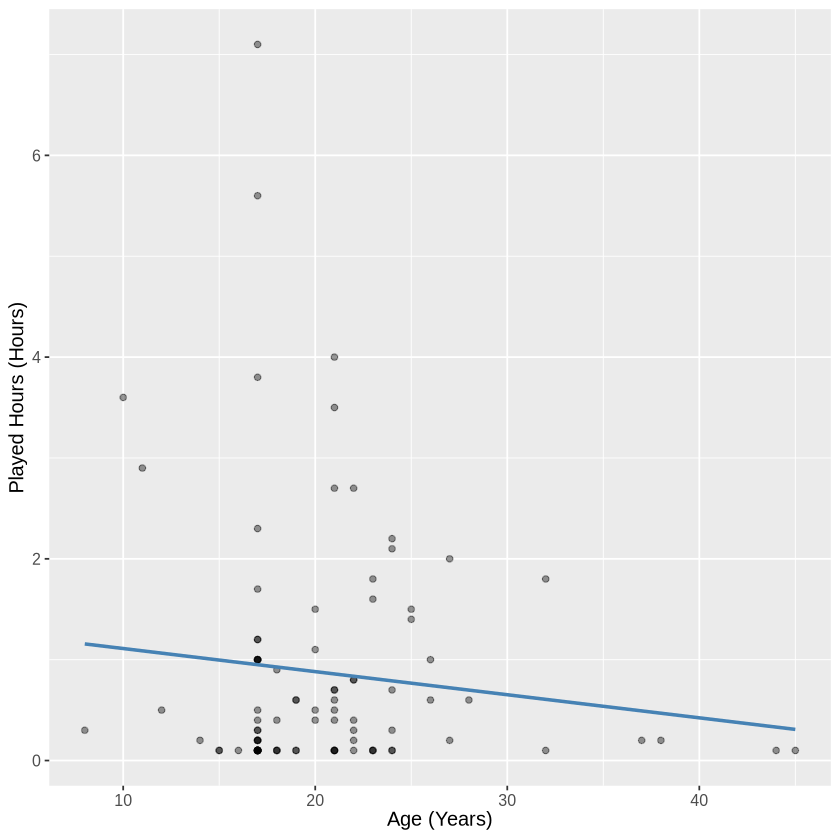

In [48]:
# Create prediction grid for age
age_prediction_grid <- tibble(
    age = c(
        filtered_players |> select(age) |> min(),
        filtered_players |> select(age) |> max()
    )
)
# Generate predictions
players_preds <- lm_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

# Plot
lm_plot_final <- ggplot(filtered_players, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = players_preds,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Age (Years)") +
  ylab("Played Hours (Hours)") +
  theme(text = element_text(size = 12))

lm_plot_final

### Linear Regression: Experience Level vs Total Hours Played

In [50]:
filtered_players <- filtered_players |>
  mutate(
    experience = factor(
      experience,
      levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
      ordered = TRUE
    )
  )


lm_recipe <- recipe(played_hours ~ experience, data = filtered_players)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = filtered_players)

lm_test_results <- lm_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.05847666
rsq,standard,0.02002637
mae,standard,0.77277180


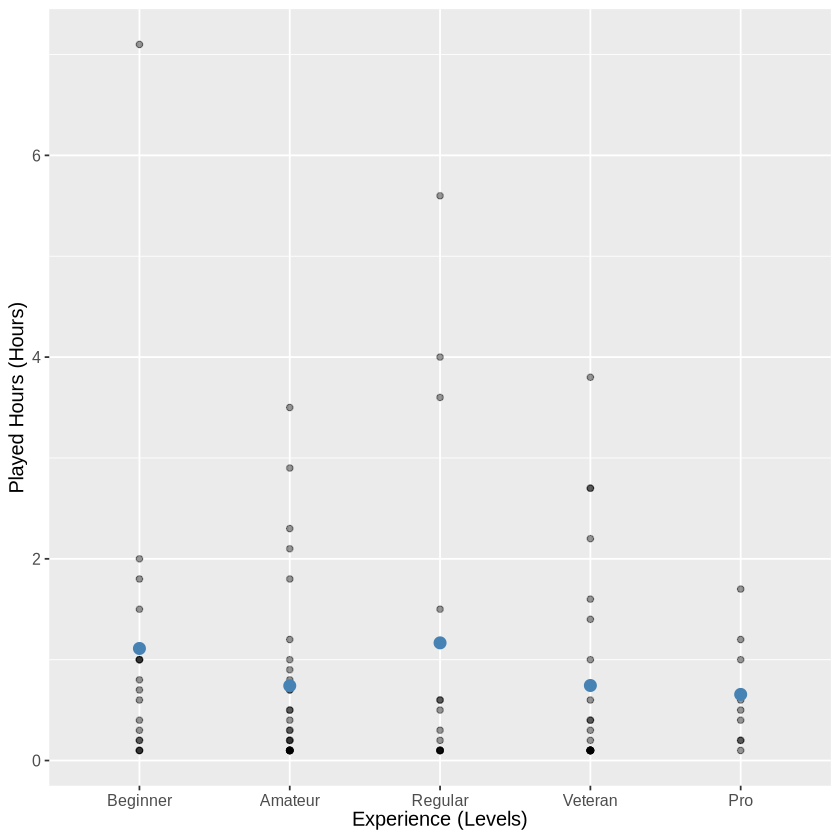

In [57]:
# Create prediction grid for experience
experience_prediction_grid <- filtered_players |> 
  select(experience) |> 
  distinct() |>
  mutate(experience = factor(experience, levels = levels(filtered_players$experience)))

# Generate predictions
players_preds <- lm_fit |>
  predict(experience_prediction_grid) |>
  bind_cols(experience_prediction_grid)

# Plot
lm_plot_final <- ggplot(filtered_players, aes(x = experience, y = played_hours)) +
  geom_point(alpha = 0.4) +  # Original data points
  geom_point(data = players_preds,  # Predicted points
             mapping = aes(x = experience, y = .pred),
             color = "steelblue", size = 3) +
  xlab("Experience (Levels)") +
  ylab("Played Hours (Hours)") +
  theme(text = element_text(size = 12))

lm_plot_final

***Discussion***

***Multivariate Regression: Age vs. Total Hours Played*** After a multivariate regression model was trained on the players.csv dataset, we found that the model explains a mere 3.07% of the variance in played_hours (R squared = 0.0307). The rmse of 1.048 indicates that model predictions are on average 1.048 hours off from the true values.

While these metrics indicate the age has a very weak relationship with total hours played, when we plot the observations we do find a weak negative relationship. Younger people tend to play more. However, this may be due to a lack of observations for people of higher age.

***Multivariate Regression: Experience vs. Total Hours Played***